#  NERC task with CoNLL 2003

This is the first part of the task dedicated to reserching *Named Entity Recognition and Classification (NERC)* task applying to the *CoNLL 2003 dataset*. In this step we need find the best way to generate markup for the dataset in the subsequent steps. Also, we will experiment with prompt engineering.


## Dataset analysis

First of all, we need to import necessery libraries and download our dataset:

In [1]:
# !pip install datasets

In [32]:
from datasets import load_dataset
import pandas as pd
from collections import Counter
import requests
from pprint import pprint
import json
import random
import multiprocessing
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
API_URL = "https://llm.ispras.ru/api/chat/completions"
API_MODEL_URL = "https://llm.ispras.ru/api/models"
API_KEY = "YOUR_TOKEN"

In [ ]:
dataset = load_dataset("eriktks/conll2003")

Let's look at the information about the dataset. We have three splits: 'train', 'validation', 'test'.

`dataset.keys()` - to see what splits we have.


In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


Let's look at the first example in our dataset:

In [6]:
pprint(dataset["test"][0])


{'chunk_tags': [11, 0, 11, 21, 11, 12, 0, 11, 13, 11, 12, 0],
 'id': '0',
 'ner_tags': [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'pos_tags': [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7],
 'tokens': ['SOCCER',
            '-',
            'JAPAN',
            'GET',
            'LUCKY',
            'WIN',
            ',',
            'CHINA',
            'IN',
            'SURPRISE',
            'DEFEAT',
            '.']}


Evaluate the number of examples:

In [7]:
for split in dataset.keys():
    dataset_split = dataset[split]
    split_len = len(dataset_split)
    print(f"Split '{split}':  {split_len} examples.")


Split 'train':  14041 examples.
Split 'validation':  3250 examples.
Split 'test':  3453 examples.



### Entity Tags

The original dataset uses named entity recognition (NER) tags in the IOB2 format.

Each token is annotated with three types of tags:
1. POS Tags: Indicate the token's grammatical role (e.g., 'NN', 'VB', etc.).
2. Chunk Tags: Specify the syntactic chunk the token belongs to (e.g., 'B-NP', 'I-NP').
3. NER Tags: Identify named entities using the IOB2 scheme:
   - 'O'      : Token is not part of any entity.
   - 'B-PER'  : Beginning of a person entity.
   - 'I-PER'  : Inside a person entity.
   - 'B-ORG'  : Beginning of an organization entity.
   - 'I-ORG'  : Inside an organization entity.
   - 'B-LOC'  : Beginning of a location entity.
   - 'I-LOC'  : Inside a location entity.
   - 'B-MISC' : Beginning of a miscellaneous entity.
   - 'I-MISC' : Inside a miscellaneous entity.

In [8]:
pos_tags = {'"': 0, "''": 1, '#': 2, '$': 3, '(': 4, ')': 5, ',': 6, '.': 7, ':': 8, '``': 9, 'CC': 10, 'CD': 11, 'DT': 12,
 'EX': 13, 'FW': 14, 'IN': 15, 'JJ': 16, 'JJR': 17, 'JJS': 18, 'LS': 19, 'MD': 20, 'NN': 21, 'NNP': 22, 'NNPS': 23,
 'NNS': 24, 'NN|SYM': 25, 'PDT': 26, 'POS': 27, 'PRP': 28, 'PRP$': 29, 'RB': 30, 'RBR': 31, 'RBS': 32, 'RP': 33,
 'SYM': 34, 'TO': 35, 'UH': 36, 'VB': 37, 'VBD': 38, 'VBG': 39, 'VBN': 40, 'VBP': 41, 'VBZ': 42, 'WDT': 43,
 'WP': 44, 'WP$': 45, 'WRB': 46}

chunk_tags = {'O': 0, 'B-ADJP': 1, 'I-ADJP': 2, 'B-ADVP': 3, 'I-ADVP': 4, 'B-CONJP': 5, 'I-CONJP': 6, 'B-INTJ': 7, 'I-INTJ': 8,
 'B-LST': 9, 'I-LST': 10, 'B-NP': 11, 'I-NP': 12, 'B-PP': 13, 'I-PP': 14, 'B-PRT': 15, 'I-PRT': 16, 'B-SBAR': 17,
 'I-SBAR': 18, 'B-UCP': 19, 'I-UCP': 20, 'B-VP': 21, 'I-VP': 22}

ner_tags = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}


Let's see the distribution of tags in the dataset:

In [30]:
def analyze_tags(dataset):
    pos_tags_counter = Counter()
    chunk_tags_counter = Counter()
    ner_tags_counter = Counter()
    
    for split in dataset.keys():
        for example in dataset[split]:
            pos_tags_counter.update(example["pos_tags"])
            chunk_tags_counter.update(example["chunk_tags"])
            ner_tags_counter.update(example["ner_tags"])
    
    print("POS Tags Distribution:", pos_tags_counter)
    print("Chunk Tags Distribution:", chunk_tags_counter)
    print("NER Tags Distribution:", ner_tags_counter)
    
    return pos_tags_counter, chunk_tags_counter, ner_tags_counter

pos_tags_counter, chunk_tags_counter, ner_tags_counter = analyze_tags(dataset)

POS Tags Distribution: Counter({22: 51545, 21: 34856, 11: 29962, 15: 28059, 12: 19773, 16: 17267, 24: 14580, 38: 12222, 7: 10898, 6: 10877, 37: 6304, 40: 5964, 30: 5852, 10: 5350, 35: 5193, 28: 4630, 4: 4233, 5: 4232, 39: 3769, 8: 3609, 42: 3439, 0: 3239, 27: 2323, 29: 2238, 41: 2132, 20: 1767, 23: 1010, 33: 784, 43: 769, 44: 769, 34: 642, 3: 622, 17: 579, 46: 551, 18: 388, 31: 259, 14: 228, 13: 210, 32: 62, 1: 60, 26: 47, 36: 42, 45: 41, 19: 37, 25: 5})
Chunk Tags Distribution: Counter({12: 99175, 11: 85016, 0: 40828, 13: 27706, 21: 26510, 22: 12902, 3: 3846, 17: 1931, 1: 1747, 15: 784, 2: 318, 4: 210, 14: 135, 7: 103, 9: 64, 6: 59, 5: 47, 18: 30, 10: 4, 16: 2, 8: 1})
NER Tags Distribution: Counter({0: 250660, 5: 10645, 1: 10059, 3: 9323, 2: 6991, 4: 5290, 7: 5062, 8: 1717, 6: 1671})


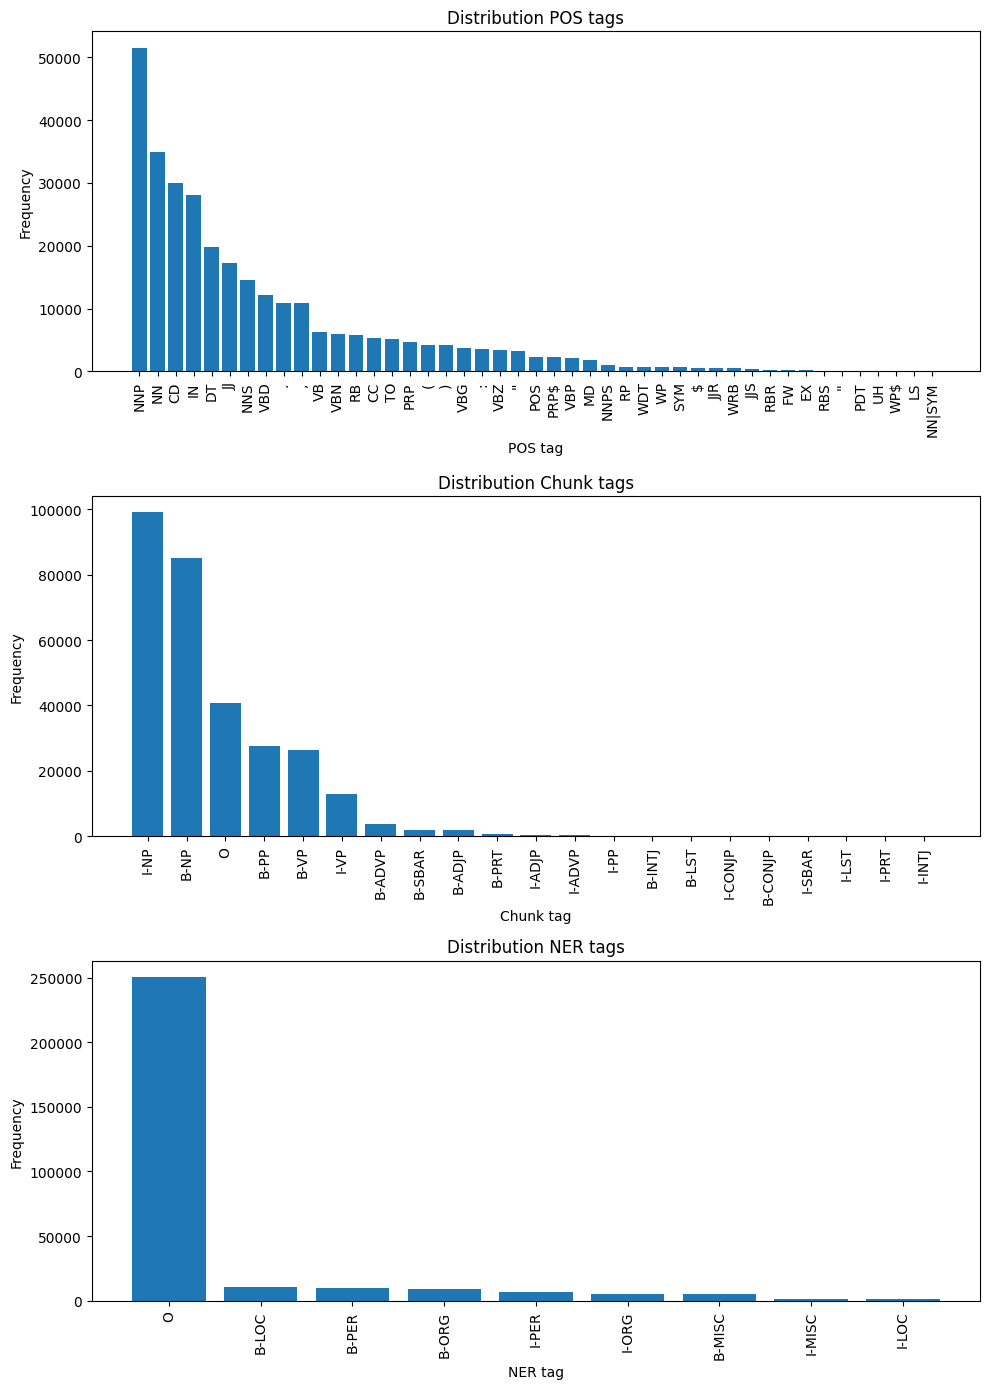

In [31]:
inv_pos_tags = {v: k for k, v in pos_tags.items()}
inv_chunk_tags = {v: k for k, v in chunk_tags.items()}
inv_ner_tags = {v: k for k, v in ner_tags.items()}

fig, axes = plt.subplots(3, 1, figsize=(10, 14))

pos_sorted = sorted(pos_tags_counter.items(), key=lambda x: x[1], reverse=True)
pos_keys, pos_values = zip(*pos_sorted)
pos_labels = [inv_pos_tags.get(k, str(k)) for k in pos_keys]

# POS tags
axes[0].bar(pos_labels, pos_values)
axes[0].set_title("Distribution POS tags")
axes[0].set_xlabel("POS tag")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=90)

chunk_sorted = sorted(chunk_tags_counter.items(), key=lambda x: x[1], reverse=True)
chunk_keys, chunk_values = zip(*chunk_sorted)
chunk_labels = [inv_chunk_tags.get(k, str(k)) for k in chunk_keys]

# Chunk tags
axes[1].bar(chunk_labels, chunk_values)
axes[1].set_title("Distribution Chunk tags")
axes[1].set_xlabel("Chunk tag")
axes[1].set_ylabel("Frequency")
axes[1].tick_params(axis='x', rotation=90)

# NER tags
ner_sorted = sorted(ner_tags_counter.items(), key=lambda x: x[1], reverse=True)
ner_keys, ner_values = zip(*ner_sorted)
ner_labels = [inv_ner_tags.get(k, str(k)) for k in ner_keys]

axes[2].bar(ner_labels, ner_values)
axes[2].set_title("Distribution NER tags")
axes[2].set_xlabel("NER tag")
axes[2].set_ylabel("Frequency")
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Sentences in the dataset


Each sentence is split into tokens. 

In [9]:
dataset.data["train"]["tokens"][0]

<pyarrow.ListScalar: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']>

To use sentences in model we need to group tokens to lists for each sentences with function `get_sentence`.

After generating we will have the batch with random sentences to send them to the model.

The function `generate_corps` takes dataset_


In [10]:
def get_sentence(dataset_name: str, idx: int) -> str: 
    return ' '.join(dataset.data[dataset_name]["tokens"][idx].values.tolist())

def generate_corps(size: int, dataset_name: str):
    data = dataset[dataset_name]
    data_size = data.shape[0]
    return (get_sentence(dataset_name, idx) 
            for idx in random.choices(range(data_size), k=size))

For example for batch of 10 random sentences:

```python
generate_corps(10, "train"), sep='\n'
```

we will have the batch of unannotated sentances.

```bash
delivered to consumer
shares outstanding
3 - Wayne Ferreira ( South Africa ) beat Jiri Novak ( Czech
LECIVA PRAHA 2470.00 2470.00 1360 3359.200
BOSTON AT CALIFORNIA
-- Helsinki Newsroom +358 - 0 - 680 50 245
More than 1,000 people have been executed in drug-related cases since the law took effect in 1989 .
In another scene , a young girl performed oral sex with an unidentified adult man .
Essex 532-8
ACC sold 9.4 million tonnes in 1995/96 , retaining its top position in the Indian cement industry , Palkhivala said .
```

In [11]:
print(*generate_corps(2, "train"), sep='\n')


This was close to the market 's forecast of net profits of 61.94 billion .
Dhar 5 Yellow 12,700-12,800 12,750-12,900


## Model requests

To make the request to the models let's make the request's head and body. And see the available models list to use them further.

In [12]:
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

Retrieve all models names:



In [13]:
def get_all_model_names():
    headers = {"Authorization": f"Bearer {API_KEY}"}
    response = requests.get(API_MODEL_URL, headers=headers)
    if response.status_code // 100 == 2:
        data = response.json()
        models = data.get("data", [])
        model_names = [model["name"] for model in models]
        return model_names
    return None

In [14]:
def get_all_model_names():
    headers = {"Authorization": f"Bearer {API_KEY}"}
    response = requests.get(API_MODEL_URL, headers=headers)
    if response.status_code == 200:
        data = response.json()
        models = data.get("data", [])
        model_names = [model["name"] for model in models]
        return model_names
    return None

In [15]:
model_names = get_all_model_names()

pprint(model_names)

['llama3.3:latest',
 'llama3.1:70b',
 'llama3.1:405b',
 'gemma2:27b',
 'mistral-large:123b',
 'command-r-plus:104b',
 'llama3.1:8b',
 'krith/qwen2.5-coder-32b-instruct:IQ3_M',
 'deepseek-coder-v2:236b',
 'llama3.2:latest',
 'mistral:7b',
 'RuadaptQwen2.5-32B-Pro-Beta:Q8',
 'deepseek-r1:14b',
 'deepseek-r1:70b',
 'deepseek-r1:7b',
 'deepseek-r1:8b',
 'qwen2.5-coder:1.5b',
 'qwen2.5-coder:32b-instruct-q8_0']


To make the body of request we construct several prompts with different description of the task to the model.

In [ ]:
prompt_1 = lambda sentence: f"Classify all named entities in a sentence and categorize their semantic meaning: '{sentence}'"

prompt_2 = lambda sentence, tags: f"Classify all named entities in a sentence: '{sentence}', based on following tags: {tags}"

prompt_3 = lambda sentence, pos_tags, chunk_tags, ner_tags: f"Classify all named entities in a sentence: '{sentence}', \
based on following parts of speech tags: {pos_tags}, \
based on following chunk tags: {chunk_tags}, \
based on following named entity recognition tags: {ner_tags}"

prompt_4 = lambda sentence, pos_tags, chunk_tags, ner_tags: f"Determine each entity that can be classified and assign them a pos_tag, a chunk_tag and a ner_tag, using following lists: \
parts of speech tags: [{pos_tags}], \
chunk tags: [{chunk_tags}], \
named entity recognition tags: [{ner_tags}] from the following: '{sentence}'." 

prompt_4_1 = lambda sentence, pos_tags, chunk_tags, ner_tags: f"Determine each entity that can be classified, split it into tokens and assign them a pos_tag, a chunk_tag and a ner_tag, using following lists: \
parts of speech tags: [{pos_tags}], \
chunk tags: [{chunk_tags}], \
named entity recognition tags: [{ner_tags}] from the following: '{sentence}'." 

prompt_5 = lambda sentences, pos_tags, chunk_tags, ner_tags: f"""Determine each entity that can be classified and assign them a pos_tag, a chunk_tag and a ner_tag, using following lists: \
parts of speech tags: [{pos_tags}], \
chunk tags: [{chunk_tags}], \
named entity recognition tags: [{ner_tags}] from the following sentences: {', '.join(f"'{sentence}'" for sentence in sentences)}."""

prompt_6 = lambda sentence, pos_tags, chunk_tags, ner_tags: f"""Identify each named entity in the sentence and classify it by the following tags:
    - POS tags: {pos_tags}
    - Chunk tags: {chunk_tags}
    - NER tags: {ner_tags}
    Sentence: '{sentence}'
    Return the response in JSON format with the fields: text, pos_tag, chunk_tag, der_tag."""




Function to generate the request's payload, accepting prompt as an argument:

In [36]:
# def gen_payload(prompt):
#     return {
#         "model": "llama3.3:latest",
#         "messages": [
#             {
#                 "role": "user", 
#                 "content": prompt
#             } 
#         ],
#         "format": "json"
#     }

# def perform_request(prompt: str):
#     return (
#         requests.post(API_URL, headers=headers, json=gen_payload(prompt))
#         .json()
#     )   

In [37]:
def perform_request(prompt: str, model: str = "llama3.3:latest"):
    payload = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}],
        "format": "json"
    }
    try:
        response = requests.post(API_URL, headers=headers, json=payload)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

def perform_requests_parallel(prompts, model: str = "llama3.3:latest"):
    with multiprocessing.Pool(10) as p:
        results = p.starmap(perform_request, [(prompt, model) for prompt in prompts])
    return results

The example response with prompt_4 we get using perform_request:

In [38]:
single_sentence = tuple(generate_corps(1, "train"))
single_prompt = prompt_4(single_sentence, pos_tags, chunk_tags, ner_tags)

response = perform_request(single_prompt)
# pprint(response)
# pprint((json.loads(response["choices"][0]["message"]["content"]), single_prompt))

To make multiprocessing request to make the responces from model faster.

In [19]:
corps = tuple(tuple(generate_corps(5, "train")) for _ in range(5))
corps

(('MARKET TALK - USDA net change in weekly export commitments for the week ended August 22 , includes old crop and new crop , were : wheat up 595,400 tonnes old , nil new ; corn up 1,900 old , up 319,600 new ; soybeans down 12,300 old , up 300,800 new ; upland cotton up 50,400 bales new , nil old ; soymeal 54,800 old , up 100,600 new , soyoil nil old , up 75,000 new ; barley up 1,700 old , nil new ; sorghum 6,200 old , up 156,700 new ; pima cotton up 4,000 bales old , nil new ; rice up 49,900 old , nil new ...',
  'On Monday , the company said it had agreed to be acquired by WorldCom Inc in a deal valued at $ 14 billion .',
  'ATRIA SEES H2 RESULT UP ON H1 .',
  'Burnley 2 Walsall 1',
  'Lokomotiva Kosice 2 Kerametal Dubnica 0'),
 ('Grand Prix athletics meeting on Friday :',
  'Goalkeepers - Oliver Kahn , Andreas Koepke , Oliver Reck',
  'Because of speculation in the market we introduced certain measures , but they are not draconian measures , and we brought it down to earth . "',
  '

Let's test prompt_5:

In [20]:
prompts = tuple(prompt_5(corp, pos_tags, chunk_tags, ner_tags) for corp in corps )
with multiprocessing.Pool(10) as p: 
    responses = p.map(perform_request, prompts)

Let's transform into dictionary the results we got from the prompt_5:

(In the prompt_5 we are trying to send to the model multiply sentences in a single request)

In [21]:
pprint([(json.loads(response["choices"][0]["message"]["content"] ), corp) for response, corp in zip(responses, corps)])

[({'entities': [{'chunk_tag': 'B-NP',
                 'entity': 'MARKET',
                 'ner_tag': 'O',
                 'pos_tag': 'NNP'},
                {'chunk_tag': 'I-NP',
                 'entity': 'TALK',
                 'ner_tag': 'O',
                 'pos_tag': 'NNP'},
                {'chunk_tag': 'B-NP',
                 'entity': 'USDA',
                 'ner_tag': 'B-ORG',
                 'pos_tag': 'NNP'},
                {'chunk_tag': 'B-NP',
                 'entity': 'August',
                 'ner_tag': 'B-MISC',
                 'pos_tag': 'NNP'},
                {'chunk_tag': 'B-NP',
                 'entity': 'wheat',
                 'ner_tag': 'O',
                 'pos_tag': 'NN'},
                {'chunk_tag': 'I-NP',
                 'entity': 'tonnes',
                 'ner_tag': 'O',
                 'pos_tag': 'NNS'},
                {'chunk_tag': 'B-NP',
                 'entity': 'corn',
                 'ner_tag': 'O',
                 'pos_tag':

Senting model too much sentences to execute maybe too long, this prompt example was working more than 5 minutes:

In [22]:
prompts = tuple(prompt_4_1(sentence, pos_tags, chunk_tags, ner_tags) for sentence in corps)
with multiprocessing.Pool(10) as p: 
    responses = p.map(perform_request, prompts)

Process ForkPoolWorker-19:
Process ForkPoolWorker-20:
Process ForkPoolWorker-14:
Process ForkPoolWorker-13:
Process ForkPoolWorker-18:
Process ForkPoolWorker-15:
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multipr

KeyboardInterrupt: 

Test our model with prompt_6:



In [26]:
prompts = tuple(prompt_6(corp, pos_tags, chunk_tags, ner_tags) for corp in corps )
with multiprocessing.Pool(10) as p: 
    responses = p.map(perform_request, prompts)

In [27]:
pprint([(json.loads(response["choices"][0]["message"]["content"] ), corp) for response, corp in zip(responses, corps)])

[({'On the other hand WorldCom announced that it will cut 2000 jobs as part of its restructuring plan .': [{'chunk_tag': 'B-NP',
                                                                                                            'ner_tag': 'O',
                                                                                                            'pos_tag': 'NNP',
                                                                                                            'text': 'On'},
                                                                                                           {'chunk_tag': 'B-NP',
                                                                                                            'ner_tag': 'O',
                                                                                                            'pos_tag': 'DT',
                                                                                                            'text': 'the

## Metrics